##INFO

this is intented to : 
- visualize INbreast dataset. 
- extracting mamogrammes from the dicom formated files.
- extracting ROI files to jpeg.
- resizing the photos to 256,256,1
- normalizing the photos
- adding Mamogrammes and ROI masks into np arrays named IN_IMAGES, IN_MASKS.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#importing the dataset from kaggle

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dnnbreastcancer","key":"33e6cf853cd6597e98d848c0a11e6f82"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ramanathansp20/inbreast-dataset -p /content/ --unzip

100% 1.92G/1.93G [00:24<00:00, 115MB/s]
100% 1.93G/1.93G [00:24<00:00, 85.3MB/s]


imports

In [8]:
from skimage.draw import polygon
import plistlib
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
from tqdm import tqdm

#Extracting the mamogrammes from dcm files

In [9]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.8 MB/s eta 0:00:00


In [10]:
import os
import pydicom
from PIL import Image
import numpy as np
from tqdm import tqdm

input_dir = '/content/INbreast Release 1.0/AllDICOMs'
output_dir = '/content/IN_JPEG/MAM'
os.makedirs(output_dir)


# Iterate through all DICOM files in the input directory
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith('.dcm'):
        # Read the DICOM file
        ds = pydicom.dcmread(os.path.join(input_dir, filename))
        
        # Extract the pixel array from the DICOM file
        pixel_array = ds.pixel_array

        # Normalize the pixel array to 0-255 since we are extracting it JPEG such it supports only 8 - bit image depth
        pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0

        # Convert the pixel array to an image
        image = Image.fromarray(pixel_array.astype(np.uint8))

        # Save the image
        image.save(os.path.join(output_dir, filename.replace('.dcm','.jpeg')))

100%|██████████| 412/412 [02:56<00:00,  2.34it/s]


#converting ROI files into jpeg

the masks are stored in .roi format using specific software and i could'nt find python library to read it but maybe we can get the roi data out from xml files in ALLXML folder. 

luckliy i we found github code that help us to do this: 
[source](https://gist.github.com/jendelel/3a8e768a8eb9345d49f2a82d02946122)


In [11]:
 
def load_inbreast_mask(mask_path, imshape=(4084, 3328)):

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [load_point(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[0]), int(point[1])] = 1
            else:
                x, y = zip(*points)
                x, y = np.array(x), np.array(y)
                poly_x, poly_y = polygon(x, y, shape=imshape)
                mask[poly_x, poly_y] = 1
    return mask

**Plotting a sample**

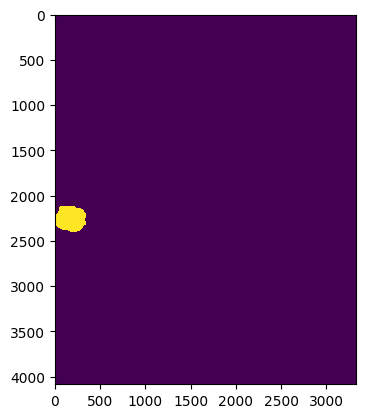

In [12]:
mask = load_inbreast_mask('/content/INbreast Release 1.0/AllXML/20588334.xml')
plt.imshow(mask, interpolation='nearest')
plt.show()

**loop to draw roi masks**

In [17]:
input_dir  = '/content/INbreast Release 1.0/AllXML'
output_dir = '/content/IN_JPEG/roi'
os.makedirs(output_dir)

for filename in tqdm(os.listdir(input_dir)):
    mask_path = os.path.join(input_dir, filename)
    if filename.endswith('.xml'):

      mask_array = load_inbreast_mask(mask_path)

      image = Image.fromarray(mask_array.astype(np.uint8))

      image.save(os.path.join(output_dir, filename.replace('.xml','.jpeg')))

100%|██████████| 343/343 [01:35<00:00,  3.59it/s]


# Images/masks to numpy

- to keep images and masks in order we will have to iterate on both of images and masks.

- when iterating on images in our directory we will extract the id which is the first first number in our image format for example: **20587638**_f4b2d377f43ba0bd_MG_L_CC_ANON.jpeg. 20587638 is the ID
- we will add this image to IN_IMAGES.NPY and add their corresponding mask to IN_MASKS.NPY


In [21]:
roi_dir = '/content/IN_JPEG/roi'
mam_dir = '/content/IN_JPEG/MAM'

#extract each file path
roi_paths = os.listdir('/content/IN_JPEG/roi') 
mam_paths = os.listdir('/content/IN_JPEG/MAM')

print(len(roi_paths))
print(len(mam_paths))

343
410


the difference indactes that there are some mammogrammes that doesn't have a roi mask 

i'll put them in IN_IMAGES_NULL just in case

In [22]:

data_length = len(roi_paths)
null_length = len(mam_paths) - data_length

#creating initialize our arrays
IN_IMAGES = np.zeros((data_length, 256,256,1))
IN_MASKS = np.zeros((data_length, 256,256,1))
IN_IMAGES_NULL = np.zeros((null_length, 256,256,1)) # images that does not have roi mask

idx = 0
idx_null = 0 
for filename in tqdm(mam_paths):
  img = None
  mask = None

  #extracting the id 
  M_ID = filename.split('_')[0]

  mam_path = os.path.join(mam_dir, filename)

  img = np.expand_dims(imread(mam_path), axis = -1)
  img = resize(img,(256,256), mode = 'constant' , preserve_range=True)
  img = img/255 #normalization

  for filename in roi_paths:
    if M_ID in filename:
        roi_path = os.path.join(roi_dir, filename)
        mask = np.expand_dims(imread(roi_path), axis = -1)
        mask = resize(mask,(256,256), mode = 'constant' , preserve_range=True)
        mask =(mask > 0).astype(np.uint8)
        break

  # making sure each image has it's mask otherwise we will drop it
  if mask is not None: 
    IN_IMAGES[idx] = img
    IN_MASKS[idx] = mask
    idx = idx + 1
  else:
    IN_IMAGES_NULL[idx_null] = img
    idx_null = idx_null + 1

100%|██████████| 410/410 [16:47<00:00,  2.46s/it]


they must have the same shape

In [23]:
print(IN_IMAGES.shape)
print(IN_MASKS.shape)

(343, 256, 256, 1)
(343, 256, 256, 1)


ploting a sample

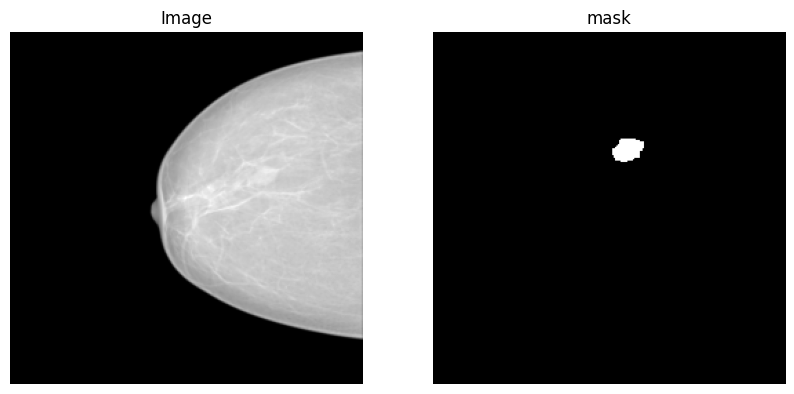

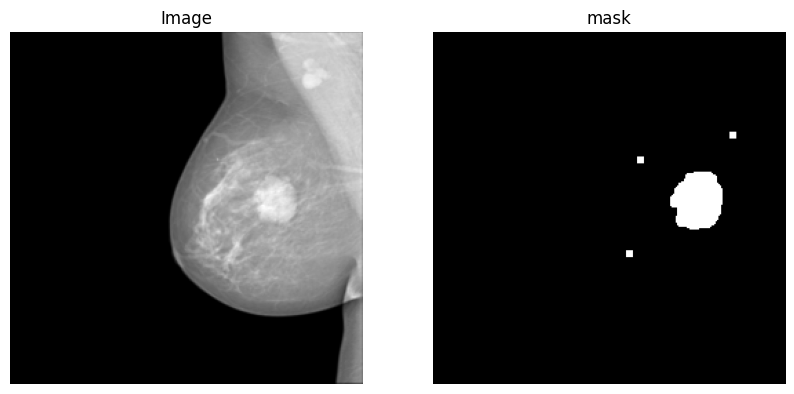

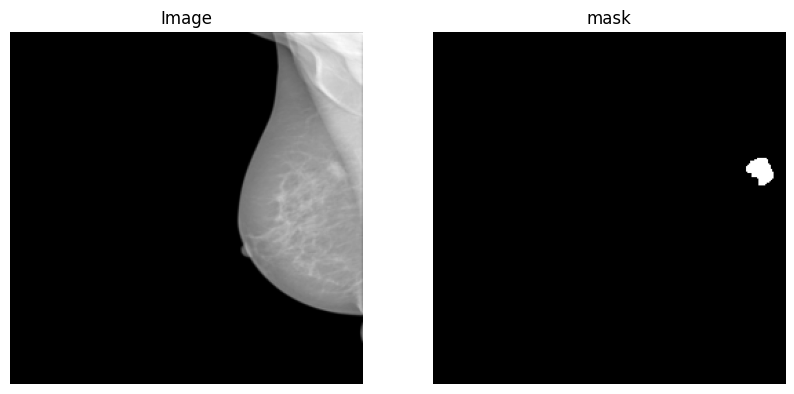

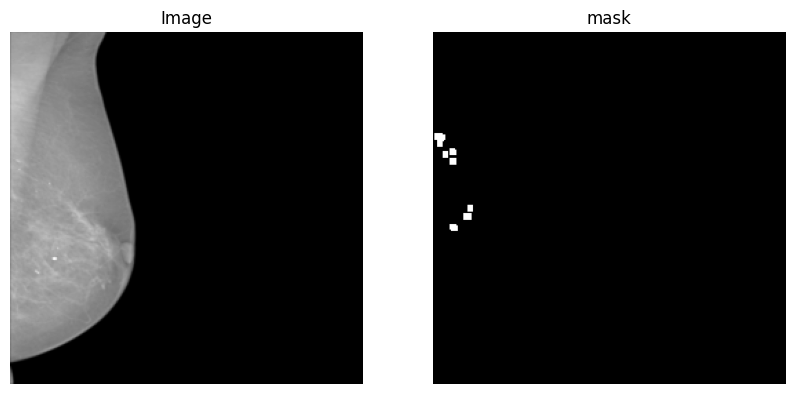

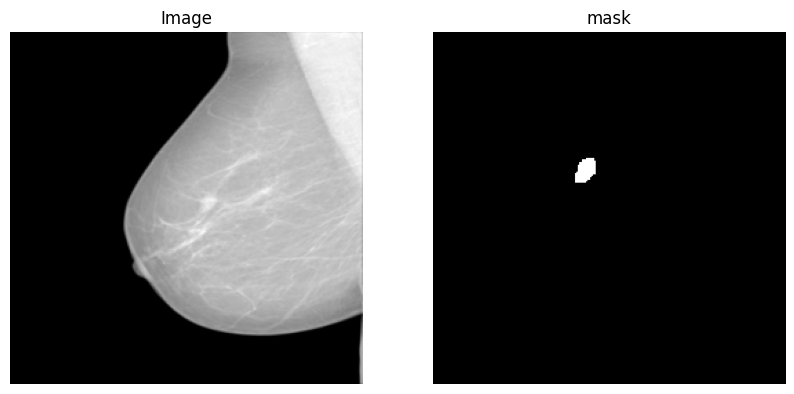

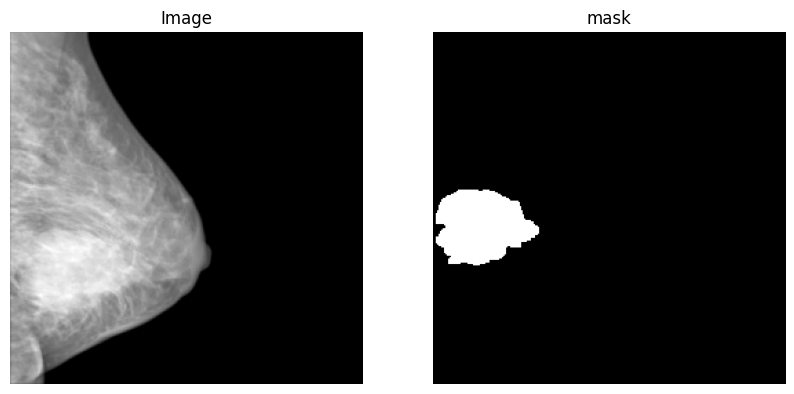

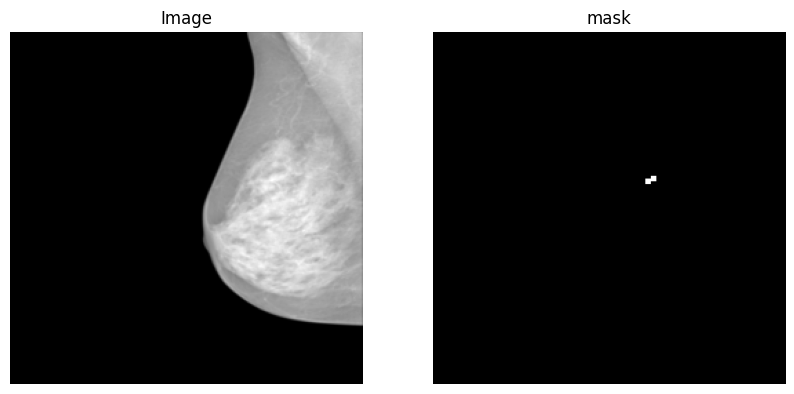

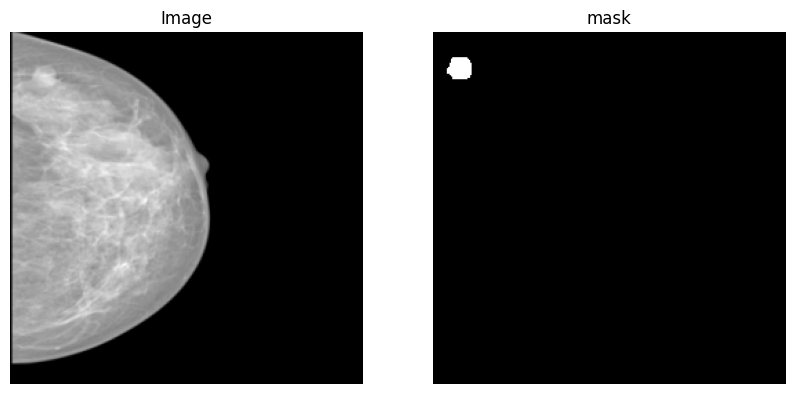

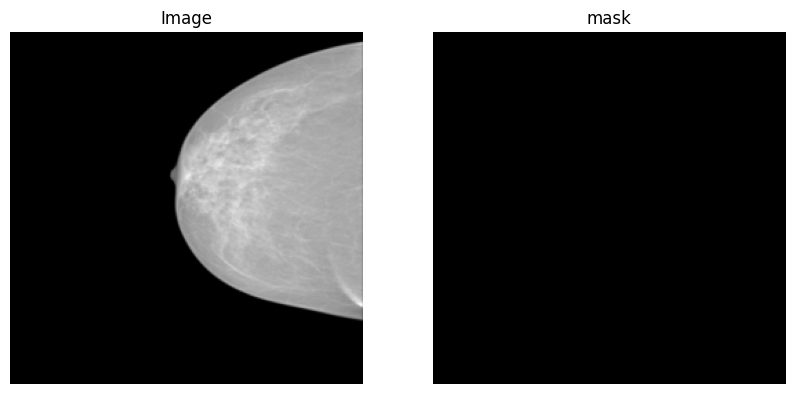

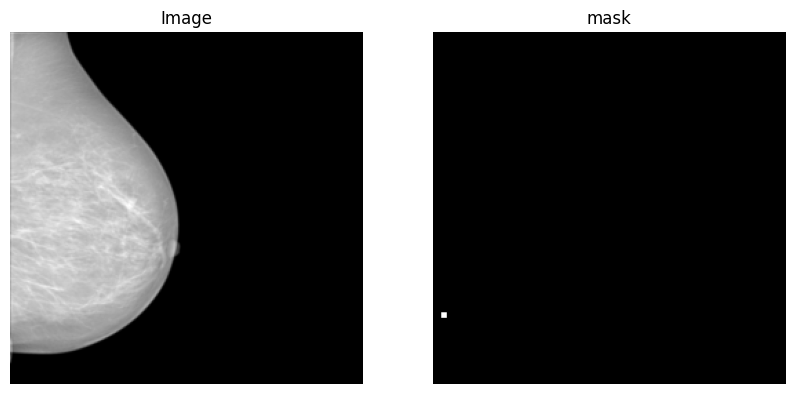

In [37]:
num_samples = 10
indices = np.random.choice(np.arange(IN_IMAGES.shape[0]), size=num_samples, replace=False)

for idx in indices:
        # Get data
        x = IN_IMAGES[idx]
        y = IN_MASKS[idx] # true mask

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot original image
        axs[0].imshow(x, cmap = 'gray')
        axs[0].set_title("Image")

        # Plot prediction
        axs[1].imshow(y, cmap='gray')
        axs[1].set_title("mask")

        # Hide the axes
        for ax in axs:
            ax.axis('off')

        plt.show()

#Saving to google drive

copy saved (jpeg) directory into drive 

In [38]:
!cp -r "/content/IN_JPEG" "/content/drive/MyDrive/Project_shared/Datasets/mammography/INBREAST"

In [42]:
!cp -r "/content/IN_JPEG/roi" "/content/drive/MyDrive/Project_shared/Datasets/mammography/INBREAST"

saving numpy arrays into drive

In [41]:
INBreas_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/INBREAST"
np.save(f'{INBreas_dir}/IN_images.npy', IN_IMAGES)
np.save(f'{INBreas_dir}/IN_masks.npy', IN_MASKS)
np.save(f'{INBreas_dir}/IN_images_null.npy', IN_IMAGES_NULL)